In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter

import re

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def parse_confusion_matrix_from_text(file_path):
  # Read the file and extract the lines representing the confusion matrix
  with open(file_path, 'r') as file:
    lines = file.readlines()  # Assuming the matrix starts from the 2nd line and ends at the 4th line
  # Convert the lines to a list of lists (confusion matrix)

  confusion_matrix = [[int(value) for value in re.sub(r"[^0-9\s]", "", line).split()] for line in lines[1:4]]
  line = lines[6]
  #print(line)
  line = line.strip()
  confusion_classes = line[line.index('[')+1:line.index(']')].split(', ')
  # Remove single quotes from each word
  confusion_classes = [word.strip("'") for word in confusion_classes]

  return [confusion_classes, confusion_matrix]



def get_precision_recall_f1(file_path, my_class):
  with open(file_path, 'r') as file:
    for line in file:
      if line.strip().startswith(my_class):
        words = line.strip().split()
        try:
          float_words = [float(word) for word in words[1:4]]
          return float_words
        except ValueError:
          return None
    return None


def get_precision_recall_f1_from_row(row, my_class):
  file_path = os.path.join(row['folder_name'], 'test_data_confusion_plot.txt')
  return get_precision_recall_f1(file_path, my_class)

def extract_metrics(row):
  #print(row)
  file_path = os.path.join(row['folder_name'], 'metrics_test inference.txt')
  #print("file_path")
  with open(file_path, 'r') as f:
    lines = f.readlines()
    #loss_index = lines.index("Metric Names: \n") + 2
    values_index = lines.index("Metrics: \n") +1
    line = lines[values_index].strip('[],\n ')
    metrics_list = [float(x) for x in line.split(",")]
    loss = metrics_list[0]
    accuracy = metrics_list[1]
  return pd.Series({'test_loss': loss, 'test_accuracy': accuracy})




In [4]:
num_epochs = 24
#agument_data means to add data ahead of time.  This should be off
# if you don't even want to balance the dataset
augment_data = [True, False]
continuous_augmentation = [True, False]
extra_to_majority = [0, 2000]
artificially_reduce_malignant_rate = [0.0, .8]
#order continuous_augmentation , augment_data, extra_to_majority, artificially_reduce_malignant_rate
params_to_plot = [
    [True, True, 2000, 0.0], #2,000 extra with continuous
    [True, True, 2000, 0.5], #2,000 extra, with 50% reduction, with continuous
    [True, True, 2000, 0.8], #2,000 extra, with 80% reduction, with continuous
    [True, True, 2000, 0.95], #2,000 extra, with 95% reduction, with continuous
]
headers = ["continuous_augmentation", "augment_data", "extra_to_majority", "reduce_malignant_rate"]
df_runs = pd.DataFrame(params_to_plot, columns=headers)

base_output_directory = './drive/MyDrive/ML/BreastCancerProject/report/'
df_runs["folder_name"] = df_runs.apply(lambda curr: base_output_directory+
                             'b_aug_data_' +
                             str(curr["augment_data"]) +
                             '_continuous_' +
                             str(curr["continuous_augmentation"]) +
                             '_extra_' + str(curr["extra_to_majority"]) +
                             '_malreduction_' +
                             str(curr["reduce_malignant_rate"])+
                             "/lime/",
                             axis=1)

df_runs.head(14)


,continuous_augmentation,augment_data,extra_to_majority,reduce_malignant_rate,folder_name
0,True,True,2000,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
1,True,True,2000,0.50,./drive/MyDrive/ML/BreastCancerProject/report/...
2,True,True,2000,0.80,./drive/MyDrive/ML/BreastCancerProject/report/...
3,True,True,2000,0.95,./drive/MyDrive/ML/BreastCancerProject/report/...


In [5]:
# Create an empty DataFrame to store the consolidated data
consolidated_df = pd.DataFrame()

# Loop over the rows of the original DataFrame
for index, row in df_runs.iterrows():
    folder_name = row['folder_name']
    csv_path = os.path.join(folder_name, 'lime_output.csv')

    # Read the CSV file into a temporary DataFrame
    temp_df = pd.read_csv(csv_path)

    # Add the 'reduce_malignant_rate' column to the temporary DataFrame
    temp_df['reduce_malignant_rate'] = row['reduce_malignant_rate']

    # Concatenate the temporary DataFrame to the consolidated DataFrame
    consolidated_df = pd.concat([consolidated_df, temp_df])

# Reset the index of the consolidated DataFrame
consolidated_df.reset_index(drop=True, inplace=True)
consolidated_df.head()


,Unnamed: 0,id,truth,pred,explanation_for_label,pos_inside_mask,pos_outside_mask,reduce_malignant_rate
0,0,9.0,benign,benign,benign,0.990972,0.610505,0.0
1,1,9.0,benign,benign,normal,0.021528,0.442427,0.0
2,2,9.0,benign,benign,malignant,0.000000,0.465735,0.0
3,3,29.0,benign,benign,benign,0.498054,0.599844,0.0
4,4,29.0,benign,benign,malignant,0.526589,0.437939,0.0


In [6]:
filtered_df = consolidated_df[consolidated_df['truth'].isin(['benign', 'malignant'])]

filtered_df = filtered_df[filtered_df['explanation_for_label'].isin(['benign', 'malignant'])]
print(filtered_df.head())
filtered_df['same_label'] = filtered_df['truth'] == filtered_df['explanation_for_label']
same_group = filtered_df[filtered_df['same_label'] == True]
different_group = filtered_df[filtered_df['same_label'] == False]

print(same_group.head())
print(different_group.head())

   Unnamed: 0     id   truth    pred explanation_for_label  pos_inside_mask  \
0           0    9.0  benign  benign                benign         0.990972   
2           2    9.0  benign  benign             malignant         0.000000   
3           3   29.0  benign  benign                benign         0.498054   
4           4   29.0  benign  benign             malignant         0.526589   
6           6  102.0  benign  benign                benign         0.998195   

   pos_outside_mask  reduce_malignant_rate  
0          0.610505                    0.0  
2          0.465735                    0.0  
3          0.599844                    0.0  
4          0.437939                    0.0  
6          0.602960                    0.0  
    Unnamed: 0     id   truth    pred explanation_for_label  pos_inside_mask  \
0            0    9.0  benign  benign                benign         0.990972   
3            3   29.0  benign  benign                benign         0.498054   
6            6 

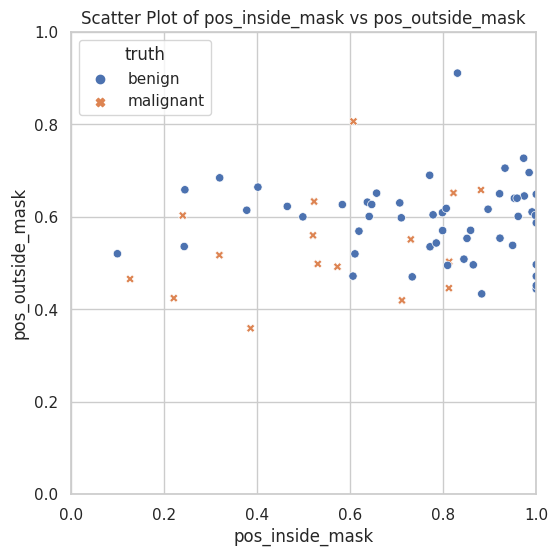

In [7]:
# Assuming same_group is your DataFrame
sns.set(style="whitegrid")  # Optional, for grid style

# Scatter plot with 'x' and 'o' markers, color-coded by the 'truth' label
plt.figure(figsize=(6, 6))  # Set the figure size to make it square

# Adjust xlim and ylim to set the range to [0, 1] on both axes
sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=same_group)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.title('Scatter Plot of pos_inside_mask vs pos_outside_mask')
plt.xlabel('pos_inside_mask')
plt.ylabel('pos_outside_mask')

plt.show()

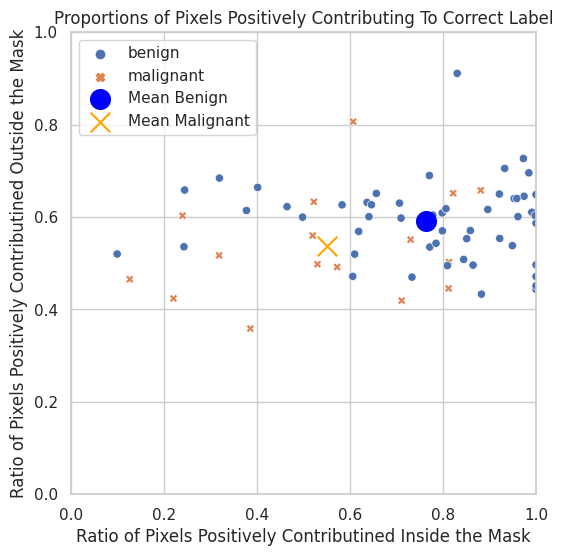

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming same_group is your DataFrame
sns.set(style="whitegrid")  # Optional, for grid style

# Scatter plot with 'x' and 'o' markers, color-coded by the 'truth' label
plt.figure(figsize=(6, 6))  # Set the figure size to make it square

# Scatter plot
sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=same_group)

# Calculate mean for 'benign' group
mean_benign = same_group[same_group['truth'] == 'benign'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Calculate mean for 'malignant' group
mean_malignant = same_group[same_group['truth'] == 'malignant'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Plot markers for the means
plt.scatter(mean_benign['pos_inside_mask'], mean_benign['pos_outside_mask'], marker='o', color='blue', s=200, label='Mean Benign')

plt.scatter(mean_malignant['pos_inside_mask'], mean_malignant['pos_outside_mask'], marker='x', color='orange', s=200, label='Mean Malignant')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.title('Proportions of Pixels Positively Contributing To Correct Label')
plt.xlabel('Ratio of Pixels Positively Contributined Inside the Mask')
plt.ylabel('Ratio of Pixels Positively Contributined Outside the Mask')
plt.legend()  # Add legend to the plot
plt.show()

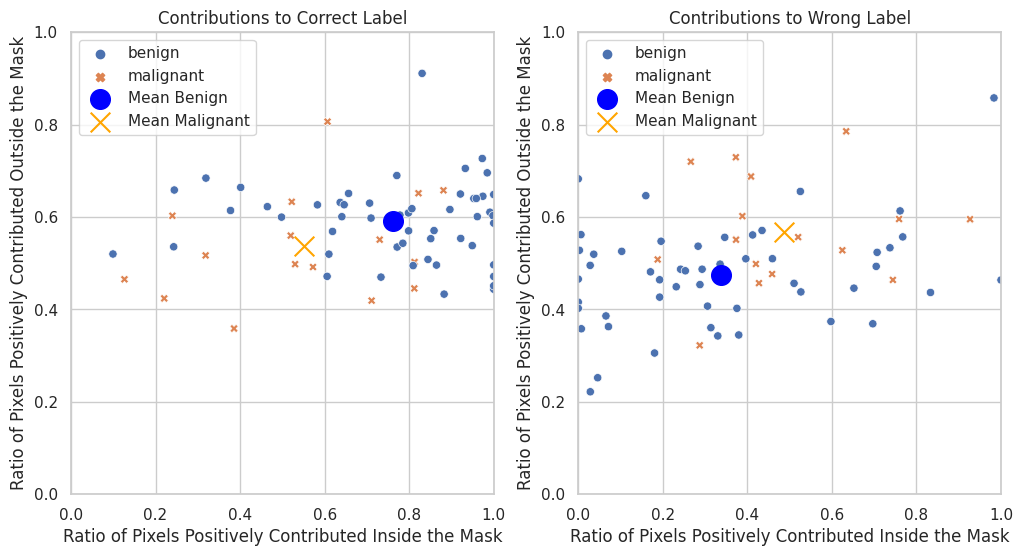

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming same_group and different_group are your DataFrames
sns.set(style="whitegrid")  # Optional, for grid style

# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Calculate mean for 'benign' group in same_group
mean_benign_s = same_group[same_group['truth'] == 'benign'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Calculate mean for 'malignant' group in same_group
mean_malignant_s = same_group[same_group['truth'] == 'malignant'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Calculate mean for 'benign' group in different_group
mean_benign_d = different_group[different_group['truth'] == 'benign'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Calculate mean for 'malignant' group in different_group
mean_malignant_d = different_group[different_group['truth'] == 'malignant'][['pos_inside_mask', 'pos_outside_mask']].mean()

# Plot for same_group
sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=same_group, ax=axes[0])

# Scatter plot mean markers for same_group
axes[0].scatter(mean_benign_s['pos_inside_mask'], mean_benign_s['pos_outside_mask'], marker='o', color='blue', s=200, label='Mean Benign')
axes[0].scatter(mean_malignant_s['pos_inside_mask'], mean_malignant_s['pos_outside_mask'], marker='x', color='orange', s=200, label='Mean Malignant')

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Ratio of Pixels Positively Contributed Inside the Mask')
axes[0].set_ylabel('Ratio of Pixels Positively Contributed Outside the Mask')
axes[0].set_title('Contributions to Correct Label')
axes[0].legend()

# Plot for different_group
sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=different_group, ax=axes[1])

# Scatter plot mean markers for different_group
axes[1].scatter(mean_benign_d['pos_inside_mask'], mean_benign_d['pos_outside_mask'], marker='o', color='blue', s=200, label='Mean Benign')
axes[1].scatter(mean_malignant_d['pos_inside_mask'], mean_malignant_d['pos_outside_mask'], marker='x', color='orange', s=200, label='Mean Malignant')

axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Ratio of Pixels Positively Contributed Inside the Mask')
axes[1].set_ylabel('Ratio of Pixels Positively Contributed Outside the Mask')
axes[1].set_title('Contributions to Wrong Label')
axes[1].legend()

output_directory = './drive/MyDrive/ML/BreastCancerProject/report/summary/'
plt.savefig(output_directory+"proportion_mal_and_benign.png")

plt.show()


In [10]:

rat_col = "Malignant Reduction Rate"
mal_col = "Malignant Positive"
ben_col = "Benign Positive"

<ipython-input-12-5567d2a2cbe5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mal_benign = mal_benign.append(new_row, ignore_index=True)
<ipython-input-12-5567d2a2cbe5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mal_benign = mal_benign.append(new_row, ignore_index=True)
<ipython-input-12-5567d2a2cbe5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mal_benign = mal_benign.append(new_row, ignore_index=True)
<ipython-input-12-5567d2a2cbe5>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mal_benign = mal_benign.append(new_row, ignore_index=True)


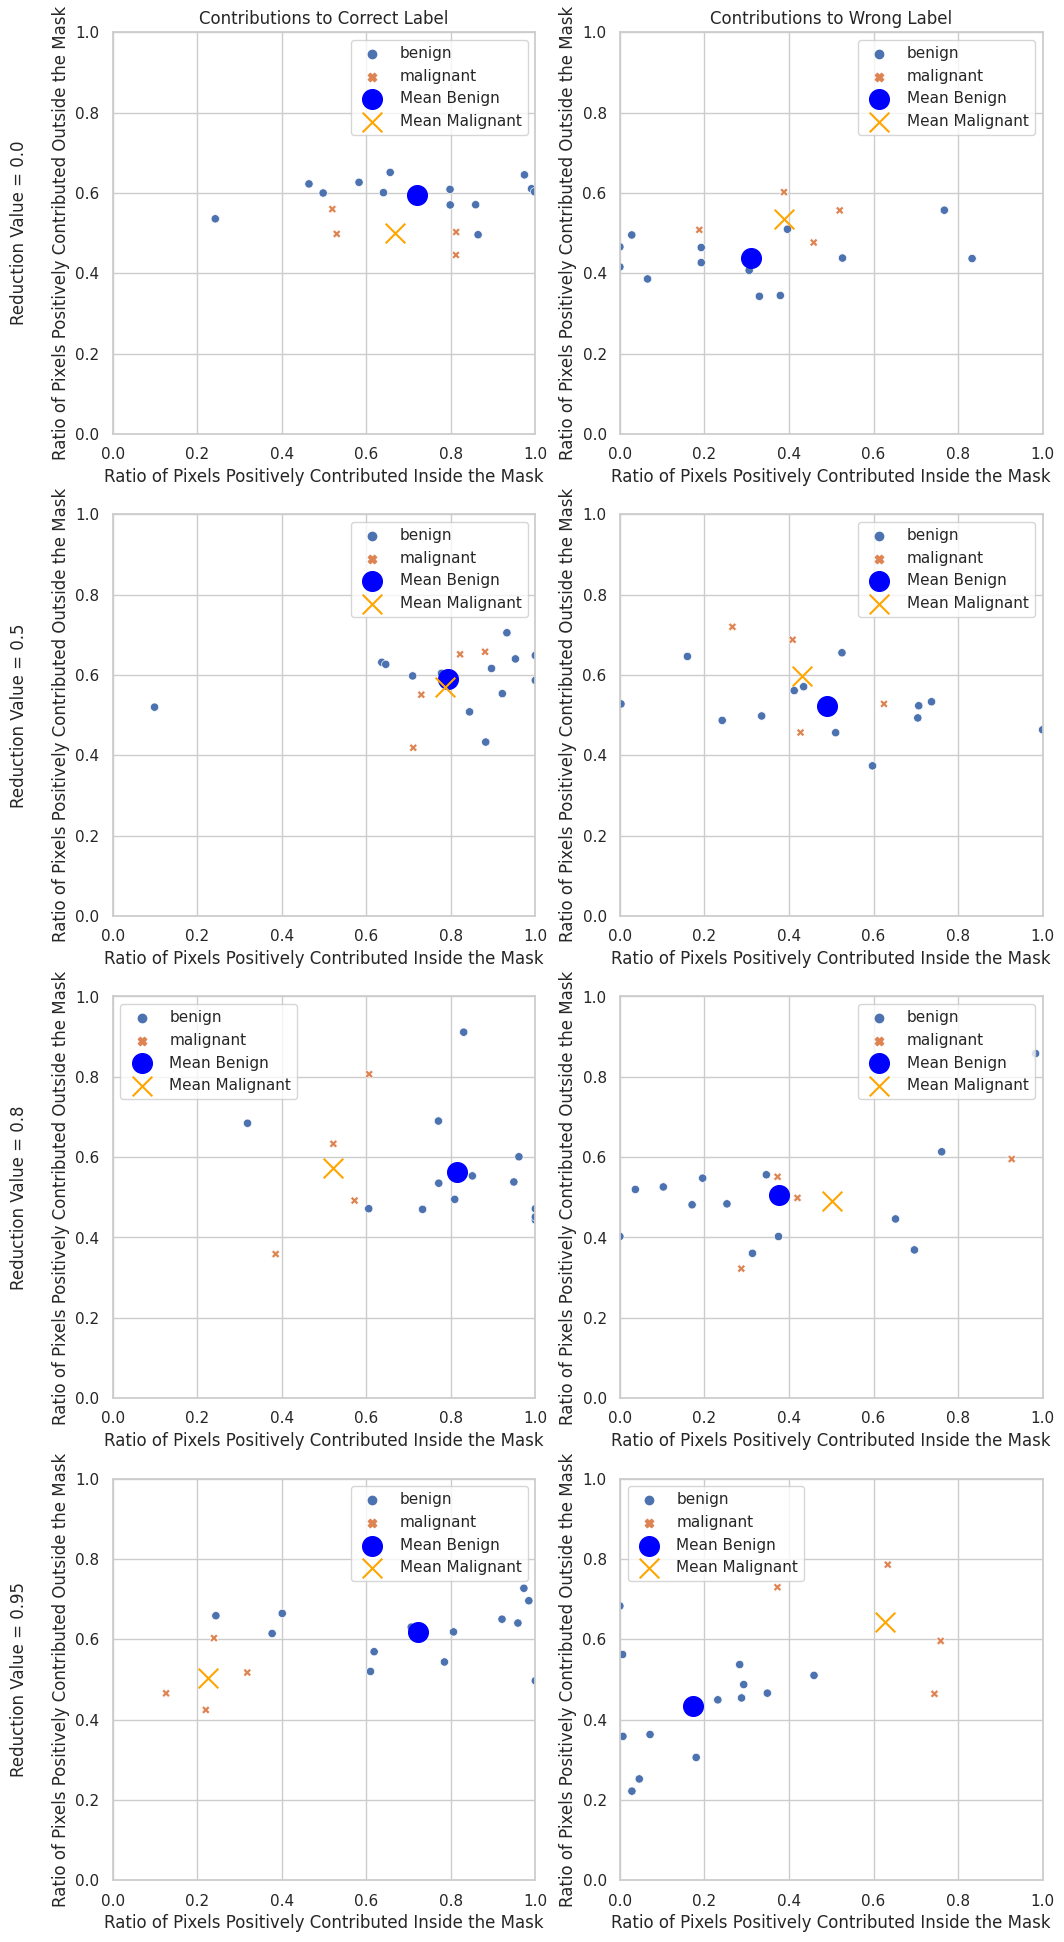

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def add_plot(same_group, different_group, reduction_value, ax):
  # Calculate mean for 'benign' group in same_group
  mean_benign_s = same_group[same_group['truth'] == 'benign'][['pos_inside_mask', 'pos_outside_mask']].mean()

  # Calculate mean for 'malignant' group in same_group
  mean_malignant_s = same_group[same_group['truth'] == 'malignant'][['pos_inside_mask', 'pos_outside_mask']].mean()

  # Calculate mean for 'benign' group in different_group
  mean_benign_d = different_group[different_group['truth'] == 'benign'][['pos_inside_mask', 'pos_outside_mask']].mean()

  # Calculate mean for 'malignant' group in different_group
  mean_malignant_d = different_group[different_group['truth'] == 'malignant'][['pos_inside_mask', 'pos_outside_mask']].mean()

  # Plot for same_group
  sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=same_group, ax=ax[0])

  # Scatter plot mean markers for same_group
  ax[0].scatter(mean_benign_s['pos_inside_mask'], mean_benign_s['pos_outside_mask'], marker='o', color='blue', s=200, label='Mean Benign')
  ax[0].scatter(mean_malignant_s['pos_inside_mask'], mean_malignant_s['pos_outside_mask'], marker='x', color='orange', s=200, label='Mean Malignant')

  ax[0].set_xlim(0, 1)
  ax[0].set_ylim(0, 1)

  ax[0].set_xlabel('Ratio of Pixels Positively Contributed Inside the Mask')
  ax[0].set_ylabel('Reduction Value = '+str(r)+'\n\nRatio of Pixels Positively Contributed Outside the Mask')

  if reduction_value < .1:
    ax[0].set_title('Contributions to Correct Label')
  ax[0].legend()

  # Plot for different_group
  sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', hue='truth', style='truth', data=different_group, ax=ax[1])

  # Scatter plot mean markers for different_group
  ax[1].scatter(mean_benign_d['pos_inside_mask'], mean_benign_d['pos_outside_mask'], marker='o', color='blue', s=200, label='Mean Benign')
  ax[1].scatter(mean_malignant_d['pos_inside_mask'], mean_malignant_d['pos_outside_mask'], marker='x', color='orange', s=200, label='Mean Malignant')

  ax[1].set_xlim(0, 1)
  ax[1].set_ylim(0, 1)
  ax[1].set_xlabel('Ratio of Pixels Positively Contributed Inside the Mask')
  ax[1].set_ylabel('Ratio of Pixels Positively Contributed Outside the Mask')
  if reduction_value < .1:
    ax[1].set_title('Contributions to Wrong Label')
  ax[1].legend()
  return [mean_malignant_s, mean_benign_s]
red = [0.0, .5, .8, .95]
# Assuming same_group and different_group are your DataFrames
sns.set(style="whitegrid")  # Optional, for grid style

# Create a figure with two subplots in a single row
fig, axes = plt.subplots(4, 2, figsize=(12, 24))  # Adjust the figure size as needed
mal_benign = pd.DataFrame(columns=[mal_col, ben_col])
i = -1
for r in red:
  i = i+1
  mal, ben = add_plot(same_group[same_group['reduce_malignant_rate'] == r], different_group[different_group['reduce_malignant_rate'] == r], r, axes[i])
  new_row = pd.Series({rat_col: r, mal_col: mal[0], ben_col: ben[0]})
  mal_benign = mal_benign.append(new_row, ignore_index=True)

output_directory = './drive/MyDrive/ML/BreastCancerProject/report/summary/'
plt.savefig(output_directory+"proportion_mal_and_benign_all.png")

plt.show()


   Malignant Positive  Benign Positive  Malignant Reduction Rate
0            0.668683         0.720736                      0.00
1            0.786134         0.792398                      0.50
2            0.521801         0.815532                      0.80
3            0.226327         0.722095                      0.95


<Figure size 800x600 with 0 Axes>

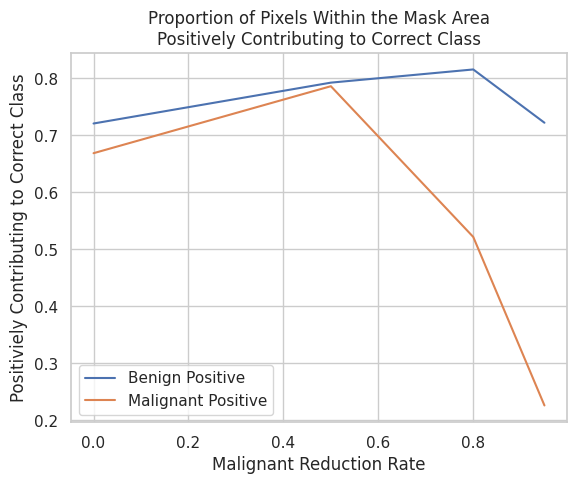

In [21]:
print(mal_benign.head())
# Plotting
plt.figure(figsize=(8, 6))

mal_benign.plot(x=rat_col, y=[ben_col, mal_col], kind='line',style={'mal_col': 'x', 'ben_col': 'o'})

plt.title('Proportion of Pixels Within the Mask Area\nPositively Contributing to Correct Class')
plt.xlabel(rat_col)
plt.ylabel('Positiviely Contributing to Correct Class')

plt.legend([ben_col, mal_col])
plt.grid(True)
plt.savefig(output_directory+"proportion_mal_and_benign_line_plot.png")
plt.show()